In [13]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os
import scipy as sp
import awkward as awk
from pylab import rcParams
rcParams['figure.figsize'] = 30, 15
rcParams['font.size'] = 19
rcParams['axes.titlesize'] = 23
from datetime import datetime as dt

In [2]:
wdir = '../1500V*'
fdirs = glob.glob(wdir)
#fdirT = (np.array(fdirT)-fdirT[0]
fdirs

['../1500V_BarrelGdLS_Co60_10mV10ns_200819_2000_samples_100000_events',
 '../1500V_BarrelGdLS_10mV10ns_200818_2000_samples_100000_events']

In [12]:
def LSRun(fname,nbase=150,cut=4,pmt=0,qbins=2000,ret=False,mrange=[0,10000]):
    waves = au.ReadDDC10_BinWave(fname)
    waves[0],base = au.Subtract_Baseline(waves[0],nBase=nbase)
    #require baseline has no pulse. i.e. integral over baseline less than cut*rms
    bmask = np.absolute(integrate.simps(waves[0][:,pmt,:nbase]))<cut*integrate.simps(np.ones(nbase))*base[1][:,pmt]
    PromptPeak = au.peakHist(waves,chan=pmt,ret=True,doplot=False)
    #Qev = 1e3*integrate.simps(waves[0][:,pmt])*au.sampleWidth_ns/au.resistance_ohm
    Qhist = au.winQHist(waves,ch=pmt,hrange=mrange,init=PromptPeak[1]-10,end=PromptPeak[1]+10,nBins=qbins,evMask=bmask[...,np.newaxis])
    if ret:
        Qhist['waves'] = waves[0][:,pmt]
        Qhist['evMask'] = bmask
        Qhist['baserms'] = base[0][:,pmt]
        return Qhist,waves[1]
    else:
        return Qhist['qHist'],waves[1]
    
def plotQ(qhist,sdir='',savef=False):
    plt.errorbar(qhist[1],qhist[0],marker='+',yerr=np.sqrt(qhist[2]))
    plt.xlabel('Q [pC]')
    plt.ylabel('dR/dQ [Hz/pC]')
    if savef:
        plt.savefig(sdir+"_QHist.png")
    plt.show()
from scipy.optimize import curve_fit

def fitQ(Qhist,P,bounds=(-np.inf,np.inf),doErr=False):
    def gauss(x, x0, y0, sigma):
        p = [x0, y0, sigma]
        return p[1]* np.exp(-((x-p[0])/p[2])**2)
    def gauss2(x,x0,y0,s0,x1,y1,s1):
        p0 = gauss(x,x0,y0,s0)
        p1 = gauss(x,x1,y1,s1)
        return p0+p1
    def gauss3(x,x0,y0,s0,x1,y1,s1,x2,y2,s2):
        p0 = gauss(x,x0,y0,s0)
        p1 = gauss(x,x1,y1,s1)
        g2 = 2*x1 - x0 +x2
        p2 = gauss(x,g2,y2,s2)
        return p0+p1+p2
    ng = len(P)/3
    mx = Qhist[1]
    my = Qhist[0]
    merr = None
    abSig = None
    if doErr:
        args = Qhist[3]
        mx = mx[args]
        my = my[args]
        merr = np.sqrt(Qhist[2][args])
        abSig = True
    if ng==3:
        fit,tmp = curve_fit(gauss3,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    elif ng==2:
        fit,tmp = curve_fit(gauss2,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    elif ng==1:
        fit,tmp = curve_fit(gauss,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    else:
        print('No valid fit function found')
        return None
    return fit,tmp

In [4]:
def fullAna(fdir,nbase=30,winS=5,winF=5,cut=4,pmt=0,qbins=2000,mirange=[0,2500],ret=False,nEV=0):
    fnames = [os.path.splitext(iF)[0] for iF in glob.glob(fdir+'/*.bin')]
    avN = len(fnames)
    if nEV>0 and nEV<avN:
        avN = nEV
    Qhist,Qinf = LSRun(fnames[0],nbase,cut,pmt,qbins,ret,mrange=mirange)
    Qhist = list(Qhist)
    totL = Qinf['totliveTime_s']
    for iQ in range(1,avN):
        Qhisti,Qinfi = LSRun(fnames[iQ],nbase,cut,pmt,qbins,ret,mrange=mirange)
        Qhist[0] += Qhisti[0]
        Qhist[2] += Qhisti[2]
        totL += Qinfi['totliveTime_s']
        #plotQ(Qhisti)
    Qhist[0] *= 1/float(avN)
    Qhist[2] *= 1/float(avN*avN)
    print(totL/avN)
    plotQ(Qhist,'../figs/'+fdir.split('/')[-1],savef=True)
    return Qhist
    """
    popt,pcov = fitQ(Qhist,[0,10,1,3,1,1])
    QNoise = min([popt[0],popt[3]])
    QSPE = max([popt[0],popt[3]])
    Qbin0 = np.argmax(Qhist[1]>QNoise)
    Qbin1 = np.argmax(Qhist[1]>QSPE)
    print(popt)
    Qvalley = np.argmax(Qhist[1]>(QSPE/5))
    
    Qbin0 = np.argmax(Qhist[1]>0)
    Qbin1 = np.argmax(Qhist[1]>2)
    Qvalley = Qbin0 + np.argmin(Qhist[0][Qbin0:Qbin1])
    DR = np.sum(Qhist[0][Qvalley:])
    DRErr = np.sqrt(np.sum(Qhist[2][Qvalley:]))
    print([fdir,Qhist[1][Qvalley],DR,DRErr])
    return DR,DRErr,Qhist
    """

470.14745031


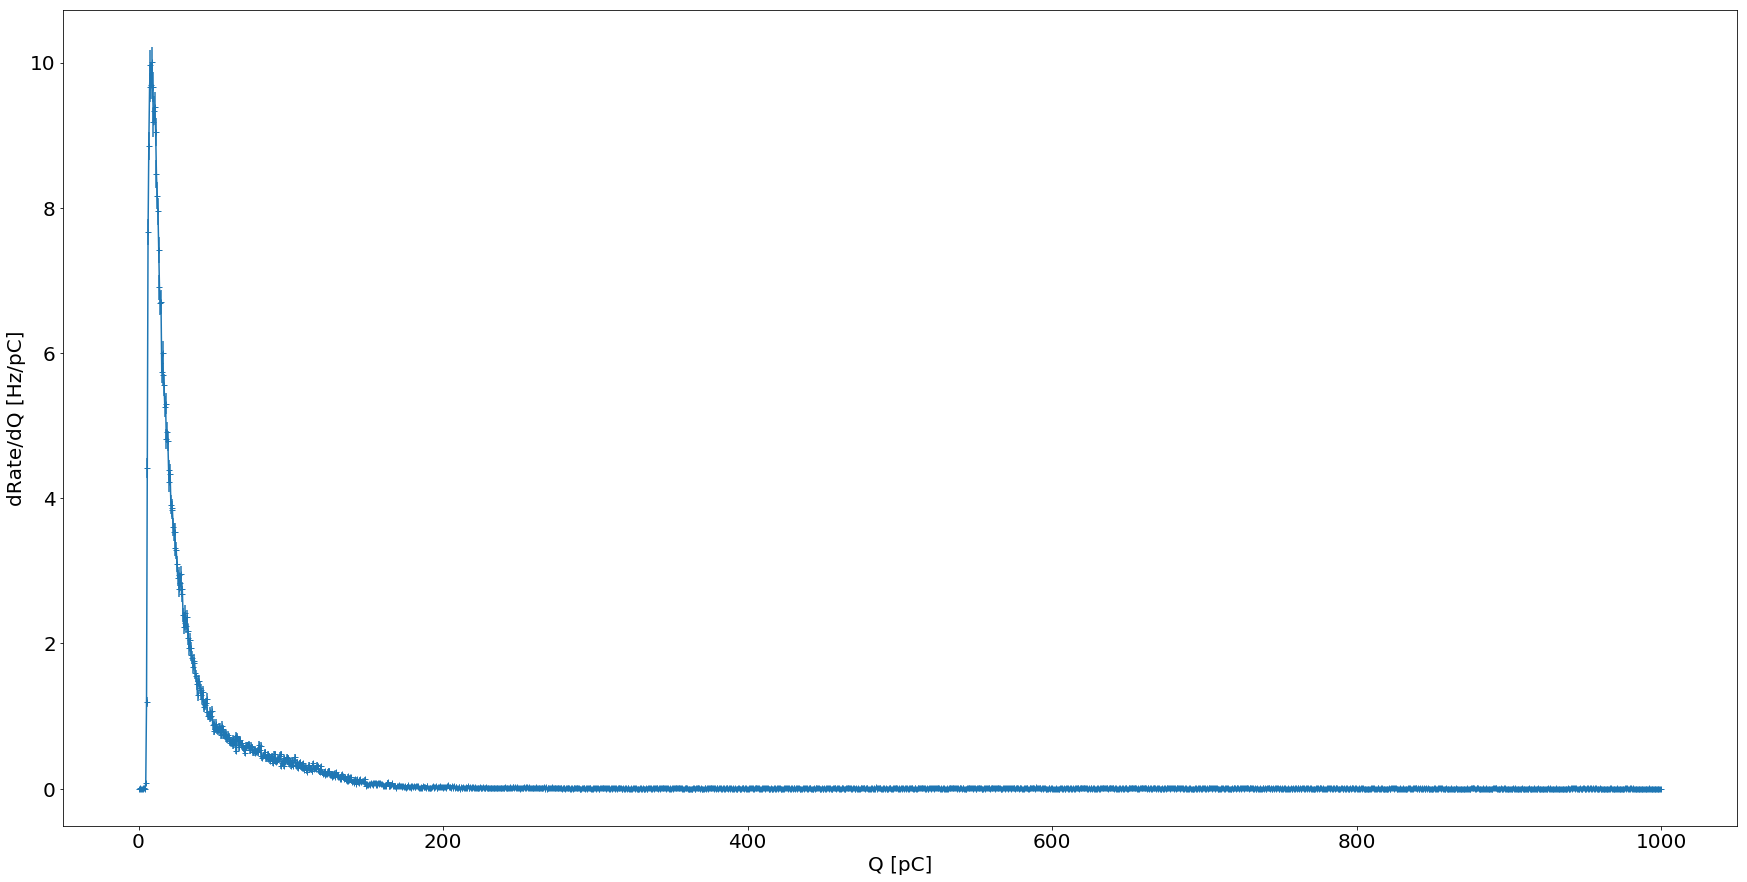

[array([0.        , 0.        , 0.00425398, ..., 0.        , 0.        ,
        0.        ]),
 array([2.5000e-01, 7.5000e-01, 1.2500e+00, ..., 9.9875e+02, 9.9925e+02,
        9.9975e+02]),
 array([0.00000000e+00, 0.00000000e+00, 1.80963847e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([   2,    5,    7, ..., 1960, 1962, 1984])]

In [11]:
fullAna(fdirs[0],nEV=1,mirange=[0,1000])

490.0218339356667


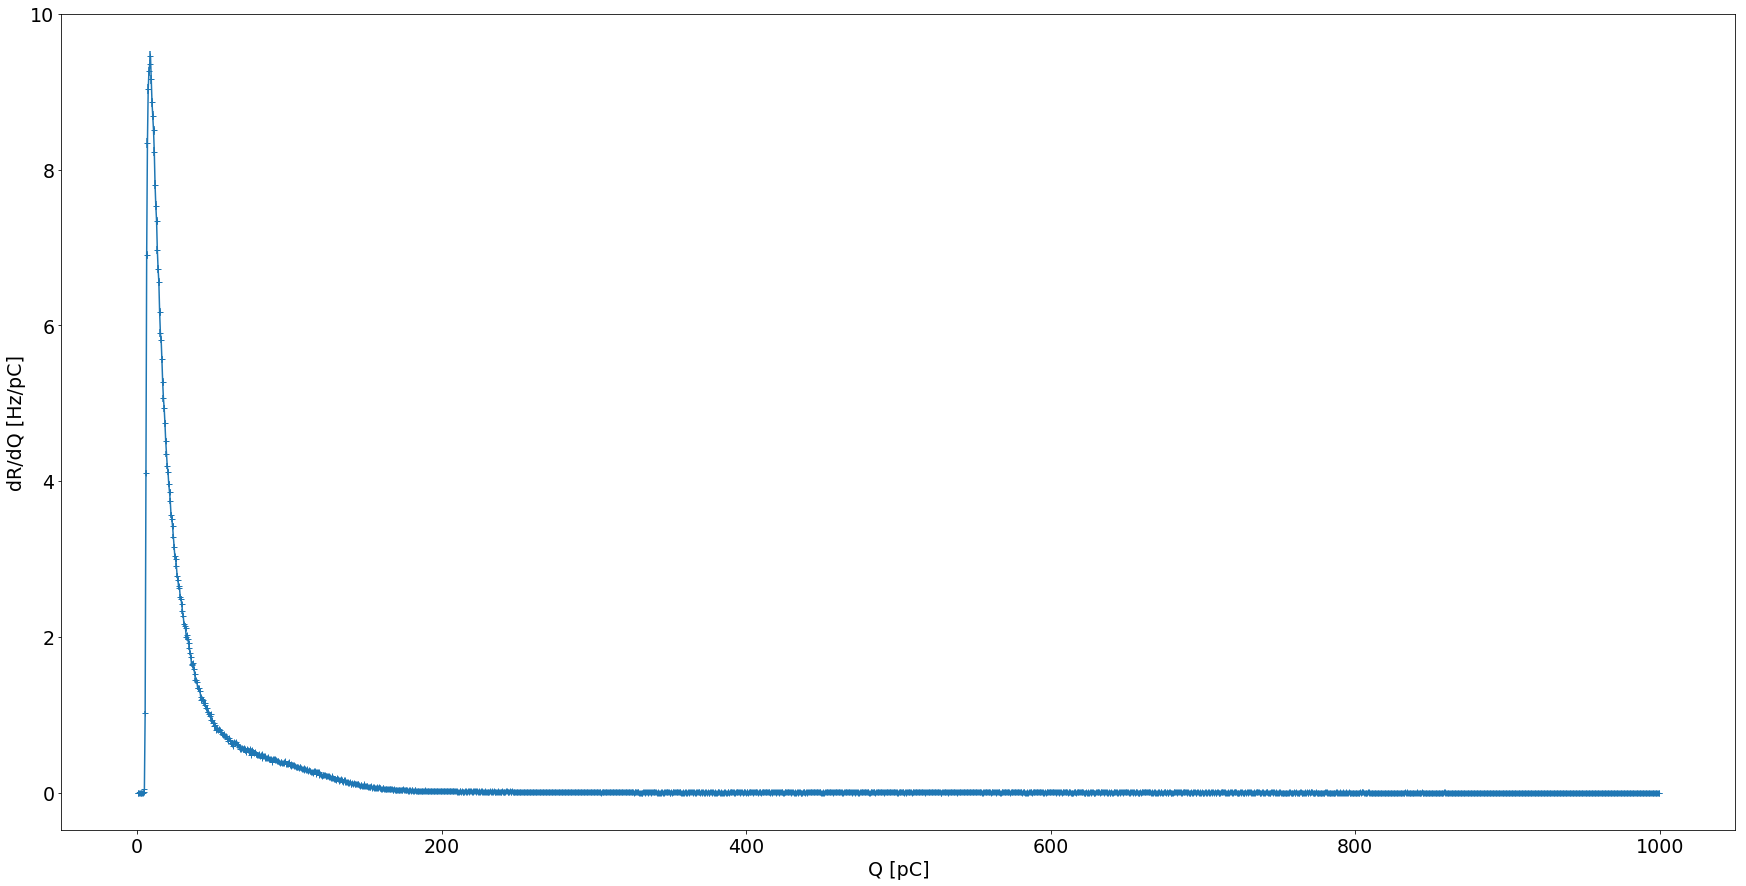

990.9288599163334


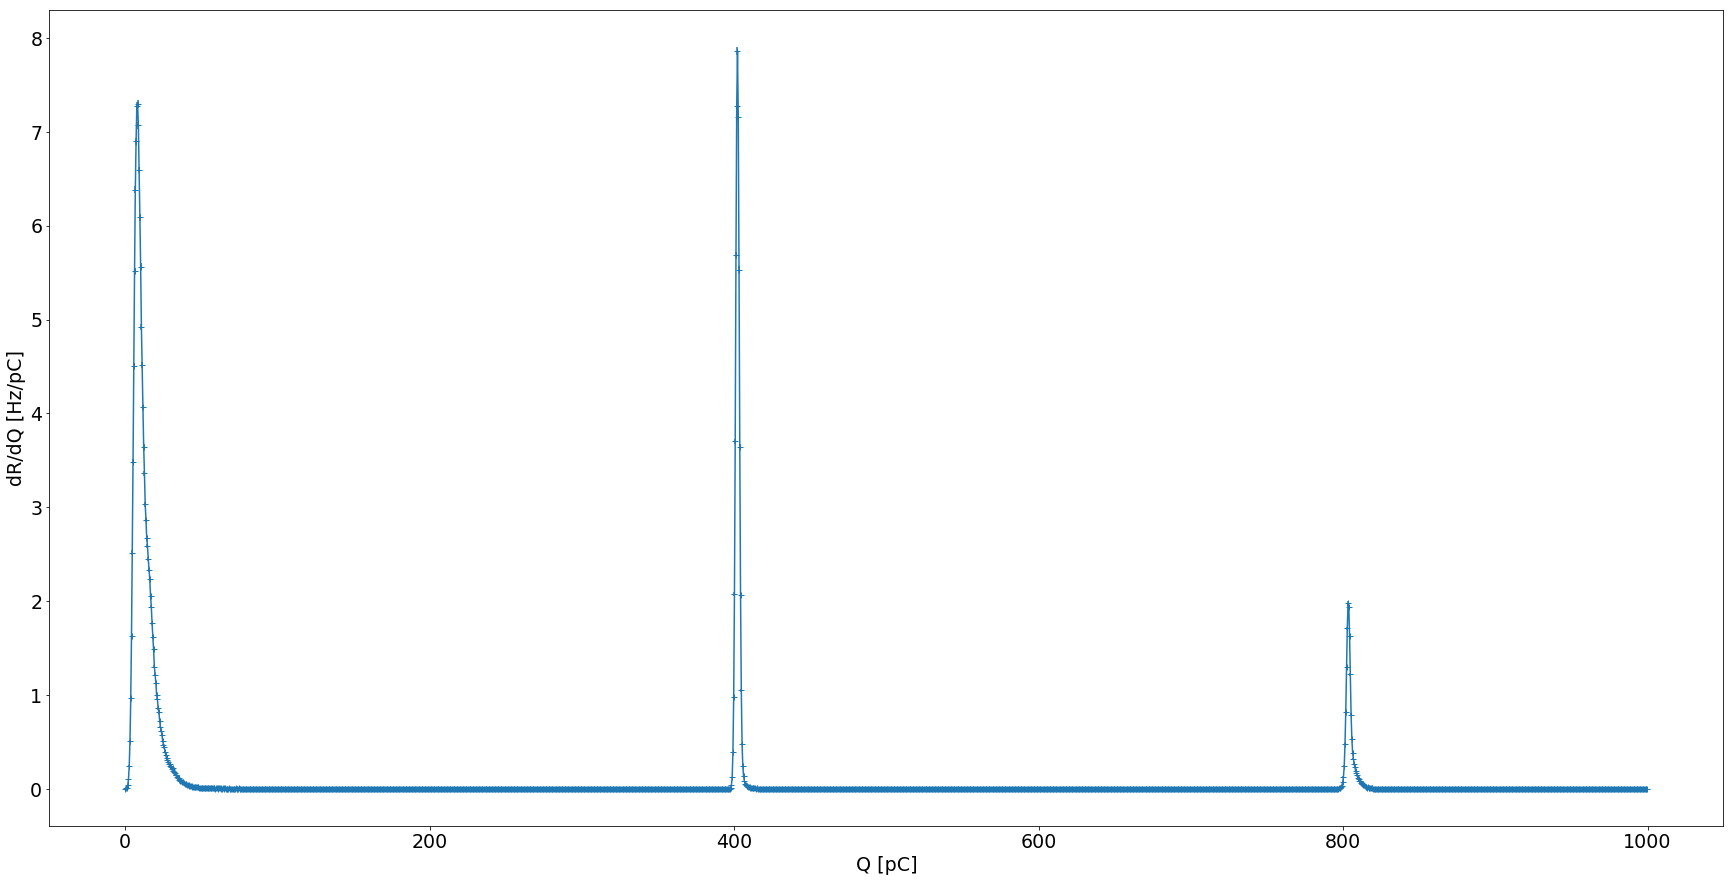

In [14]:
allRuns = [fullAna(iF,nEV=10,mirange=[0,1000]) for iF in fdirs]

In [ ]:
#from scipy import integrate
for i in range(len(fdirs)):
    myInt = integrate.simps(allRuns[i][0],allRuns[i][1])
    plt.errorbar(allRuns[i][1],allRuns[i][0],marker='+',yerr=allRuns[i][2],label=fdirs[i].split('/')[-1]+'_Integral:{}'.format(myInt))
plt.xlabel('Q [pC]')
plt.ylabel('dR/dQ [Hz/pC]')
plt.legend()
plt.savefig("../figs/Qhist.png")
plt.show()


<Figure size 2160x1080 with 0 Axes>